Exploratory Data Analysis

In [75]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

cashrequest_df = pd.read_csv("project_dataset/cashreq-clean.csv")
fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")
print("✅ done!")

✅ done!


/var/folders/bx/bzgj6qhd5_l2_b7d0v7r7r7r0000gn/T/ipykernel_11501/1143823055.py:7: DtypeWarning: Columns (29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")


In [76]:
# cashrequest_df.head()
fees_and_cohorts_df.head()

,Unnamed: 0,fee_id,cash_request_id,type,fee_status,category,total_amount,fee_reason,fee_created_at,fee_updated_at,...,recovery_status,reco_creation,reco_last_update,was_moderated,was_deleted_account,was_sent,was_money_back,invalid_date_sequence,user_first_cash_request_date,cohort
0,0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,...,pending,2020-10-11 22:52:52.274832+00,2020-12-20 22:40:42.556534+00,False,False,True,True,False,2020-09-07 10:46:57.780263+00:00,2020-09
1,1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,...,completed,2020-09-09 20:51:17.992852+00,2020-10-10 22:58:13.306027+00,True,False,True,True,False,2020-06-21 18:38:39.791418+00:00,2020-06
2,2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,...,NaN,NaN,NaN,False,False,True,True,False,2020-10-23 10:10:43.278601+00:00,2020-10
3,3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00,2020-10-31 15:46:53.643982+00,...,NaN,NaN,NaN,False,False,True,True,False,2020-10-31 15:46:14.156730+00:00,2020-10
4,4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00,2020-10-13 14:25:03.267983+00,...,completed,2020-10-24 22:43:13.278707+00,2020-11-02 14:45:20.333109+00,True,True,True,True,False,2020-06-27 18:06:04.818312+00:00,2020-06


## LTV per user / cohort

In [77]:
# Ingreso total generado por los usuarios de cada cohorte / Número de usuarios en la cohorte
# Los gráficos representarán el LTV promedio por usuario de cada cohorte.

In [78]:
# Q1: Sumar ingresos per user / cohort
accepted_fees = fees_and_cohorts_df[fees_and_cohorts_df['fee_status'].isin(['accepted', 'confirmed'])]

user_total_per_cohort = accepted_fees.groupby(["cohort", "user_id"])["total_amount"].sum().reset_index()
user_total_per_cohort.head()

,cohort,user_id,total_amount
0,2019-11,47.0,30.0
1,2019-12,52.0,10.0
2,2019-12,53.0,5.0
3,2019-12,77.0,5.0
4,2019-12,92.0,15.0


In [79]:
# Q2: Revenue promedio per user / cohort
avg_revenue_per_user_by_cohort = user_total_per_cohort.groupby("cohort")["total_amount"].mean().reset_index()
avg_revenue_per_user_by_cohort.columns = ["cohort", "avg_revenue_per_user"]
avg_revenue_per_user_by_cohort.head()

,cohort,avg_revenue_per_user
0,2019-11,30.000000
1,2019-12,13.674699
2,2020-01,13.939394
3,2020-02,14.545455
4,2020-03,14.444444


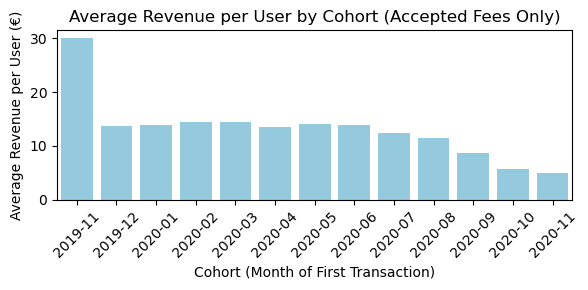

'🧠 Interpretation of Results:\n✅ 2019-11 cohort has the highest average revenue per user, by far — almost $50 per user, which may indicate:\n+ Very engaged early adopters\n+ A small but high-value user base\n+ Or longer time to accumulate revenue\n\n📉 From 2019-12 to mid-2020, average revenue per user remains fairly stable (~$18–$21) — these cohorts might have more consistent behavior.\n\n⬇️ Starting around 2020-08, there’s a clear downward trend:\nCohorts like 2020-09, 2020-10, and 2020-11 show much lower user value, around $5–$10 per user, this could indicate:\n+ Decreased user engagement\n+ Shorter lifetime (users haven\'t been active long enough)\n+ Lower conversion or retention quality\n+ Or you’re acquiring lower-value users as you scale"\n'

In [80]:
# Q2 Plotting
plt.figure(figsize=(6, 3))
sns.barplot(
    data=avg_revenue_per_user_by_cohort,
    x="cohort",
    y="avg_revenue_per_user",
    color="skyblue"
)

# Titles and labels
plt.title("Average Revenue per User by Cohort (Accepted Fees Only)")
plt.xlabel("Cohort (Month of First Transaction)")
plt.ylabel("Average Revenue per User (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

"""🧠 Interpretation of Results:
✅ 2019-11 cohort has the highest average revenue per user, by far — almost $50 per user, which may indicate:
+ Very engaged early adopters
+ A small but high-value user base
+ Or longer time to accumulate revenue

📉 From 2019-12 to mid-2020, average revenue per user remains fairly stable (~$18–$21) — these cohorts might have more consistent behavior.

⬇️ Starting around 2020-08, there’s a clear downward trend:
Cohorts like 2020-09, 2020-10, and 2020-11 show much lower user value, around $5–$10 per user, this could indicate:
+ Decreased user engagement
+ Shorter lifetime (users haven't been active long enough)
+ Lower conversion or retention quality
+ Or you’re acquiring lower-value users as you scale"
"""


In [81]:
# Q3: Ver en cuántas cohorts ha estado cada usuario
cohorts_per_user = fees_and_cohorts_df.groupby("user_id")["cohort"].nunique().reset_index()
cohorts_per_user.columns = ["user_id", "num_cohorts_active"]
cohorts_per_user.head()

,user_id,num_cohorts_active
0,47.0,1
1,52.0,1
2,53.0,1
3,72.0,1
4,73.0,1


In [82]:
# Q4: Asociar a cada user con su cohort de entrada (primer préstamo):
user_first_cohort = accepted_fees.groupby("user_id")["cohort"].min().reset_index()
user_first_cohort.columns = ["user_id", "cohort_start"]
# Unir con el número de cohorts activos
user_lifetime_df = pd.merge(user_first_cohort, cohorts_per_user, on="user_id")

# Calcular duración promedio por cohorte
# Ahora, para cada cohort de entrada (cohort_start), sacamos el promedio de cohorts activos por usuario:
avg_duration_per_cohort = user_lifetime_df.groupby("cohort_start")["num_cohorts_active"].mean().reset_index()
avg_duration_per_cohort.columns = ["cohort", "avg_num_cohorts_active"]

# Ya tenemos el ingreso promedio por usuario (paso anterior), ahora, unirlo y multiplicar:
ltv_by_cohort = pd.merge(avg_revenue_per_user_by_cohort, avg_duration_per_cohort, on="cohort")

# Calculamos LTV por user
ltv_by_cohort["LTV"] = ltv_by_cohort["avg_revenue_per_user"] * ltv_by_cohort["avg_num_cohorts_active"]
ltv_by_cohort

,cohort,avg_revenue_per_user,avg_num_cohorts_active,LTV
0,2019-11,30.000000,1.0,30.000000
1,2019-12,13.674699,1.0,13.674699
2,2020-01,13.939394,1.0,13.939394
3,2020-02,14.545455,1.0,14.545455
4,2020-03,14.444444,1.0,14.444444
5,2020-04,13.547009,1.0,13.547009
6,2020-05,14.007092,1.0,14.007092
7,2020-06,13.967181,1.0,13.967181
8,2020-07,12.321232,1.0,12.321232
9,2020-08,11.399549,1.0,11.399549


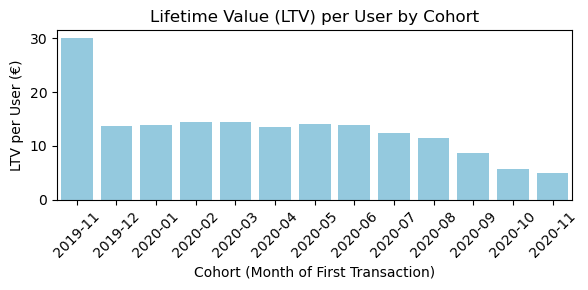

In [83]:
# Q4: Plotting

plt.figure(figsize=(6, 3))
sns.barplot(
    data=ltv_by_cohort,
    x="cohort",
    y="LTV",
    color="skyblue"
)
plt.title("Lifetime Value (LTV) per User by Cohort")
plt.xlabel("Cohort (Month of First Transaction)")
plt.ylabel("LTV per User (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [84]:
# Q5: Separar el fee por tipo (solo aceptados)
revenue_by_user_type = accepted_fees.groupby(["cohort", "user_id", "type"])["total_amount"].sum().reset_index()

# Promedio por tipo y cohort
avg_revenue_by_type = revenue_by_user_type.groupby(["cohort", "type"])["total_amount"].mean().reset_index()
avg_revenue_by_type.columns = ["cohort", "fee_type", "avg_revenue_per_user"]
avg_revenue_by_type

,cohort,fee_type,avg_revenue_per_user
0,2019-11,instant_payment,20.000000
1,2019-11,postpone,10.000000
2,2019-12,incident,7.592593
3,2019-12,instant_payment,9.000000
4,2019-12,postpone,8.333333
5,2020-01,incident,6.666667
6,2020-01,instant_payment,8.387097
7,2020-01,postpone,9.411765
8,2020-02,incident,7.500000
9,2020-02,instant_payment,10.000000


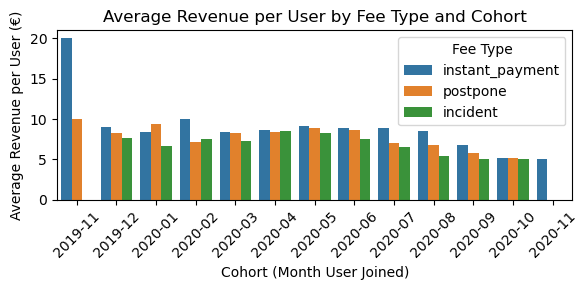

In [85]:
#Q5: Plotting

plt.figure(figsize=(6, 3))
sns.barplot(
    data=avg_revenue_by_type,
    x="cohort",
    y="avg_revenue_per_user",
    hue="fee_type"
)
plt.title("Average Revenue per User by Fee Type and Cohort")
plt.xlabel("Cohort (Month User Joined)")
plt.ylabel("Average Revenue per User (€)")
plt.xticks(rotation=45)
plt.legend(title="Fee Type")
plt.tight_layout()
plt.show()

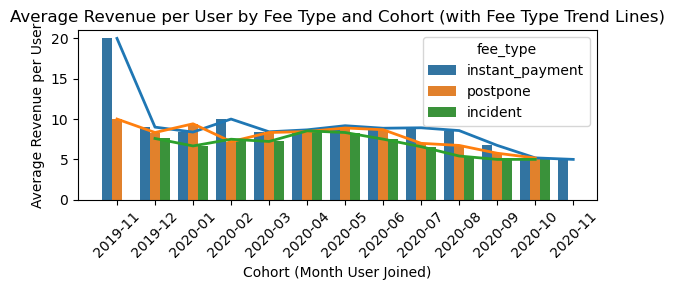

In [86]:
plt.figure(figsize=(6, 3))

# Barras por tipo de fee
sns.barplot(
    data=avg_revenue_by_type,
    x="cohort",
    y="avg_revenue_per_user",
    hue="fee_type"
)

# Línea por tipo de fee (superpuesta)
sns.lineplot(
    data=avg_revenue_by_type,
    x="cohort",
    y="avg_revenue_per_user",
    hue="fee_type",
    markers=True,
    linewidth=2,
    legend=False  # opcional si ya está la leyenda arriba
)

plt.title("Average Revenue per User by Fee Type and Cohort (with Fee Type Trend Lines)")
plt.xlabel("Cohort (Month User Joined)")
plt.ylabel("Average Revenue per User")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Interpretation of Results:

✅ 2019-11 cohort has the highest average revenue per user, by far — almost $20 per user.
+ Users generated almost €20 in instant_payment fees alone, more than any other fee type.

which may indicate:
+ Very engaged early adopters
+ A small but high-value user base
+ Or longer time to accumulate revenue

📉 From 2019-12 to mid-2020, average revenue per user remains fairly stable (+-€10) — these cohorts might have more consistent behavior.
+ postpone remains dominant, but not as extreme as in 2019-11.

⬇️ Starting around 2020-08, there’s a clear downward trend (all fee types):
Cohorts like 2020-09, 2020-10, and 2020-11 show much lower user value, around €5 per user, this could indicate:
+ Decreased user engagement
+ Shorter lifetime (users haven't been active long enough)
+ Lower conversion or retention quality
+ Or you’re acquiring lower-value users as you scale"

🧩 The incident fee type:
+ Has a relatively consistent presence since 2020-01.

## User Lifetime Value (uLTV)

In [88]:
#User Lifetime Value (uLTV)
# uLTV =
# (Average Revenue Per User = ingresos promedio por usuario en un período.)
# ×
# Lifetime (Lifetime = duración promedio del usuario como cliente, en cohorts)

/var/folders/bx/bzgj6qhd5_l2_b7d0v7r7r7r0000gn/T/ipykernel_11501/3050764253.py:8: DtypeWarning: Columns (29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  fees_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")


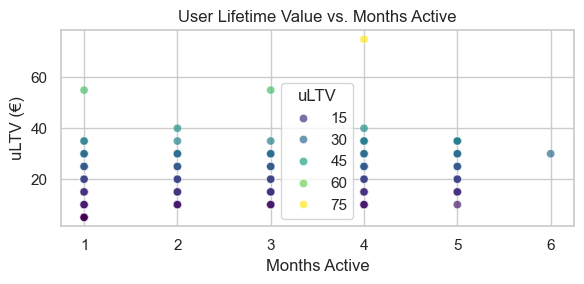

'"\n📊 Insights from uLTV Trend Analysis\n\nModest correlation between uLTV and time\nWhile there’s a slight upward trend, most users reach their peak value within the first few months.\n\nHigh-value users emerge early\nA significant number of users generate high uLTV in just 1–2 months, highlighting the importance of strong onboarding and early engagement.\n\nRetention beyond month 4 flattens\nuLTV gains taper off after month 3–4, suggesting current long-term engagement strategies may not be unlocking additional value.\n\nAlmost no users reach month 6\nThis could indicate user churn before that point, or a gap in product lifecycle or re-engagement efforts.\n\n\n📌 Strategic Takeaways\n\nFocus on maximizing value in the first month through onboarding, and marketing actions.\nImplement retention loops before month 3 to avoid early drop-off.\nExplore why users aren’t reaching month 6 — and design long-term incentives to retain and grow lifetime value over time.\n'

In [101]:

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# 1: Load datasets
cashrequest_df = pd.read_csv("project_dataset/cashreq-clean.csv")
fees_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")

# 2: Filter only accepted fees
accepted_fees_df = fees_df[fees_df["fee_status"].isin(['accepted', 'confirmed'])]


# 3: Merge with cash requests
merged_df = accepted_fees_df.merge(
    cashrequest_df[["cash_request_id", "user_id", "cash_request_created_at"]],
    on="cash_request_id",
    how="left"
)

# 4: Handle datetime and ID columns safely
if "cash_request_created_at_y" in merged_df.columns:
    merged_df["created_at"] = pd.to_datetime(merged_df["cash_request_created_at_y"], errors="coerce")
else:
    merged_df["created_at"] = pd.to_datetime(merged_df["cash_request_created_at"], errors="coerce")

if "user_id_y" in merged_df.columns:
    merged_df["user_id"] = merged_df["user_id_y"]

# 5: Drop rows with invalid or missing dates
merged_df = merged_df.dropna(subset=["created_at"])

# 6: Calculate months active per user
user_activity = merged_df.groupby("user_id")["created_at"].agg(["min", "max"]).reset_index()
user_activity["months_active"] = ((user_activity["max"] - user_activity["min"]) / pd.Timedelta(days=30)).apply(lambda x: max(1, round(x)))

# 7: Count number of accepted fees per user
user_tx_count = merged_df.groupby("user_id").size().reset_index(name="num_transactions")

# 8: Sum total accepted fees per user
user_fees = merged_df.groupby("user_id")["total_amount"].sum().reset_index()
user_fees.rename(columns={"total_amount": "total_fees"}, inplace=True)

# 9: Merge all components
final_df = user_fees.merge(user_tx_count, on="user_id").merge(user_activity[["user_id", "months_active"]], on="user_id")

# 10: Calculate uLTV components
final_df["avg_transaction_value"] = final_df["total_fees"] / final_df["num_transactions"]
final_df["transaction_frequency"] = final_df["num_transactions"] / final_df["months_active"]
final_df["uLTV"] = final_df["avg_transaction_value"] * final_df["transaction_frequency"] * final_df["months_active"]

# 11: Sort by uLTV descending
final_df = final_df.sort_values(by="uLTV", ascending=False)

# 12: Save output
os.makedirs("output", exist_ok=True)
final_df.to_csv("output/user_fees_by_month.csv", index=False)

# 13: Plot uLTV vs Months Active
sns.set(style="whitegrid")
plt.figure(figsize=(6, 3))
sns.scatterplot(
    data=final_df,
    x="months_active",
    y="uLTV",
    hue="uLTV",
    palette="viridis",
    alpha=0.7
)
plt.title("User Lifetime Value vs. Months Active")
plt.xlabel("Months Active")
plt.ylabel("uLTV (€)")
plt.tight_layout()
plt.show()

""""
📊 Insights from uLTV Trend Analysis

Modest correlation between uLTV and time
While there’s a slight upward trend, most users reach their peak value within the first few months.

High-value users emerge early
A significant number of users generate high uLTV in just 1–2 months, highlighting the importance of strong onboarding and early engagement.

Retention beyond month 4 flattens
uLTV gains taper off after month 3–4, suggesting current long-term engagement strategies may not be unlocking additional value.

Almost no users reach month 6
This could indicate user churn before that point, or a gap in product lifecycle or re-engagement efforts.


📌 Strategic Takeaways

Focus on maximizing value in the first month through onboarding, and marketing actions.
Implement retention loops before month 3 to avoid early drop-off.
Explore why users aren’t reaching month 6 — and design long-term incentives to retain and grow lifetime value over time.
"""